# Same problem/success as log_ret_many_indicators...

In [1]:
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
from ue.uexp.dataprocessing.ta import *
from ue.uexp.models.util import *

#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta
#=========================
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20, 10)

import warnings
warnings.filterwarnings('ignore')

# Introduction

We use MLP, multiple variables ([log_ret_0, ..., log_ret_29, volume, spread, log_price_change, ...] to predict -> log_return")

## Predicting on
- log_return of price at next timestep

## Data + preprocessing

In [2]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2022-02-03"
end_date = "2022-02-04"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-02.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-03.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2022-02-04.csv


In [3]:
df.drop(["tic"], axis=1, inplace=True)
df.columns = ["Open","High","Low","Close","Volume"]

## Adding TAs

#### Volatility Indicators

In [4]:
#df.head(50)

#### Momentum Indicators
- Rate of change (ROC)
- Relative Strenght Index (RSI)
- Stochastic RSI (sRSI, srsi_k, srsi_d)
- True Strength Index (TSI)

In [5]:
window = 30 # a choice
# df[f"roc_{window}"] = ta.momentum.ROCIndicator(close=df["Close"], window=window).roc()

# TSI Indicator
df["momentum_tsi"] = TSIIndicator(
    close=df["Close"], window_slow=25, window_fast=13, fillna=True
).tsi()/100 #scale 0-1

## Drop OHL, stationize C, and related

In [6]:
def stationize(series):
    return np.log(series / series.shift(1))

In [7]:
df.head()

,Open,High,Low,Close,Volume,momentum_tsi
2022-02-03 00:00:00,36896.37,36907.62,36896.36,36902.96,5.20868,0.000000
2022-02-03 00:00:01,36902.97,36902.97,36902.80,36902.81,0.05825,-1.000000
2022-02-03 00:00:02,36901.10,36901.11,36896.39,36899.19,0.72231,-1.000000
2022-02-03 00:00:03,36899.19,36900.54,36895.53,36900.54,0.40235,-0.871596
2022-02-03 00:00:04,36900.53,36900.54,36895.62,36895.62,0.32702,-0.833150


In [8]:
# store initial price to reconstruct it back from returns
# initialprices = {
#     "Close": df['Close'][0],
#     "volume_vwap": ,
#     "trend_sma_slow",
#     "trend_ema_slow":
# }
# the initial price is at 00:00:00
df['log_ret'] = stationize(df['Close'])
# df['log_volume_vwap_ret'] = stationize(df['volume_vwap'])
# df['log_trend_sma_slow_ret'] = stationize(df['trend_sma_slow'])
# df['log_trend_ema_slow_ret'] = stationize(df['trend_ema_slow'])

In [9]:
df.drop(["Open","High","Low", "Volume"], axis=1, inplace=True)

In [10]:
#df.dropna(inplace=True)

## Make Windowed dataset (using dt_feats1)

In [11]:
HORIZON = 1
WINDOW = 30

In [12]:
# Add windowed columns
for i in range(WINDOW-1): # Shift values for each step in WINDOW_SIZE
  df[f"log_ret+{i+2}"] = df["log_ret"].shift(periods=i+2)
df.head(50)

,Close,momentum_tsi,log_ret,log_ret+2,log_ret+3,log_ret+4,log_ret+5,log_ret+6,log_ret+7,log_ret+8,...,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29,log_ret+30
2022-02-03 00:00:00,36902.96,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:01,36902.81,-1.000000,-4.064723e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:02,36899.19,-1.000000,-9.810032e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:03,36900.54,-0.871596,3.658550e-05,-4.064723e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:04,36895.62,-0.833150,-1.333403e-04,-9.810032e-05,-4.064723e-06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:05,36900.26,-0.600366,1.257523e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:06,36898.71,-0.504129,-4.200601e-05,-1.333403e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:07,36898.71,-0.450333,0.000000e+00,1.257523e-04,-1.333403e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:08,36898.71,-0.416051,0.000000e+00,-4.200601e-05,1.257523e-04,-1.333403e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-03 00:00:09,36896.07,-0.416555,-7.154978e-05,0.000000e+00,-4.200601e-05,1.257523e-04,-1.333403e-04,3.658550e-05,-9.810032e-05,-4.064723e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.dropna().shape

(172769, 32)

In [14]:
df.shape

(172800, 32)

In [15]:
#drop non-stationized values, keeping them for later reconstruction
X = df.dropna().drop(["Close"], axis=1).astype(np.float32) 

#note, starting at :30second
X.head()

,momentum_tsi,log_ret,log_ret+2,log_ret+3,log_ret+4,log_ret+5,log_ret+6,log_ret+7,log_ret+8,log_ret+9,...,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29,log_ret+30
2022-02-03 00:00:31,-0.326270,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000037,-0.000032,-0.000094,-0.000123,...,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133,0.000037,-0.000098,-0.000004
2022-02-03 00:00:32,-0.221396,0.000299,0.000373,0.000000,0.000000,0.000000,0.000000,-0.000037,-0.000032,-0.000094,...,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133,0.000037,-0.000098
2022-02-03 00:00:33,-0.144487,-0.000010,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000,-0.000037,-0.000032,...,-0.000259,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133,0.000037
2022-02-03 00:00:34,-0.083675,0.000010,0.000299,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000,-0.000037,...,0.000249,-0.000259,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126,-0.000133
2022-02-03 00:00:35,-0.031504,0.000027,-0.000010,0.000299,0.000000,0.000373,0.000000,0.000000,0.000000,0.000000,...,-0.000151,0.000249,-0.000259,-0.000184,0.000184,-0.000072,0.000000,0.000000,-0.000042,0.000126


In [16]:
X.shape

(172769, 31)

In [17]:
y = df.dropna().drop(["Close"], axis=1)["log_ret"].astype(np.float32)
y.head()

2022-02-03 00:00:31    0.000000
2022-02-03 00:00:32    0.000299
2022-02-03 00:00:33   -0.000010
2022-02-03 00:00:34    0.000010
2022-02-03 00:00:35    0.000027
Freq: S, Name: log_ret, dtype: float32

In [18]:
y.shape

(172769,)

### Train val test split: (first 60% training, next 20% validation, last 20% for evaluation)

In [19]:
# #train80%, validate 20%-1, test on last datapoint
# split_size_1 = int(len(X) * 0.8)
# X_train, y_train = X[:split_size_1], y[:split_size_1]
# X_val, y_val = X[split_size_1:-1], y[split_size_1:-1]
# X_test, y_test = X[-1:], y[-1:]
# len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

In [20]:
split_size_1 = int(len(X) * 0.6)
split_size_2 = int(len(X) * 0.8)
X_train, y_train = X[:split_size_1], y[:split_size_1]
X_val, y_val = X[split_size_1:split_size_2], y[split_size_1:split_size_2]
X_test, y_test = X[split_size_2:], y[split_size_2:]
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(103661, 103661, 34554, 34554, 34554, 34554)

## Model building and fitting

In [21]:
tf.keras.backend.clear_session()

In [22]:
# Make multivariate time series model
model_dense_multivariate = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_dense_multivariate")

# Compile
model_dense_multivariate.compile(loss="mae",
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=['mse','mape','mae'])

Metal device set to: Apple M1 Pro


2022-02-08 15:08:27.682574: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-08 15:08:27.682715: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
# Fit
history = model_dense_multivariate.fit(X_train, y_train,
                                       epochs=1, #saw that 20 was good enough
                                       batch_size=128,
                                       verbose=1, # progress bar
                                       validation_data=(X_val, y_val),
                                       callbacks=[create_model_checkpoint(model_name=model_dense_multivariate.name)])

2022-02-08 15:08:27.742825: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 10/810 [..............................] - ETA: 4s - loss: 0.0089 - mse: 1.3925e-04 - mape: 2945267.7500 - mae: 0.0089  

2022-02-08 15:08:27.965031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


806/810 [============================>.] - ETA: 0s - loss: 8.1007e-04 - mse: 3.4534e-06 - mape: 266925.9688 - mae: 8.1007e-04

2022-02-08 15:08:32.655687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
810/810 [==============================] - 6s 7ms/step - loss: 8.0810e-04 - mse: 3.4382e-06 - mape: 266320.5312 - mae: 8.0810e-04 - val_loss: 3.5515e-04 - val_mse: 1.5821e-07 - val_mape: 125314.3047 - val_mae: 3.5515e-04


2022-02-08 15:08:33.453338: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [24]:
model_dense_multivariate.summary()

Model: "model_dense_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4096      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,737
Trainable params: 20,737
Non-trainable params: 0
_________________________________________________________________


In [25]:
import pydot

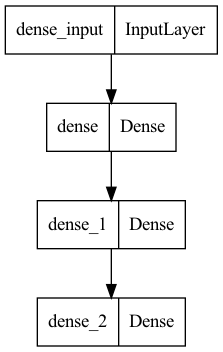

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(model_dense_multivariate)

## Examining Histories

In [27]:
import matplotlib.pyplot as plt

In [28]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'mape', 'mae', 'val_loss', 'val_mse', 'val_mape', 'val_mae'])


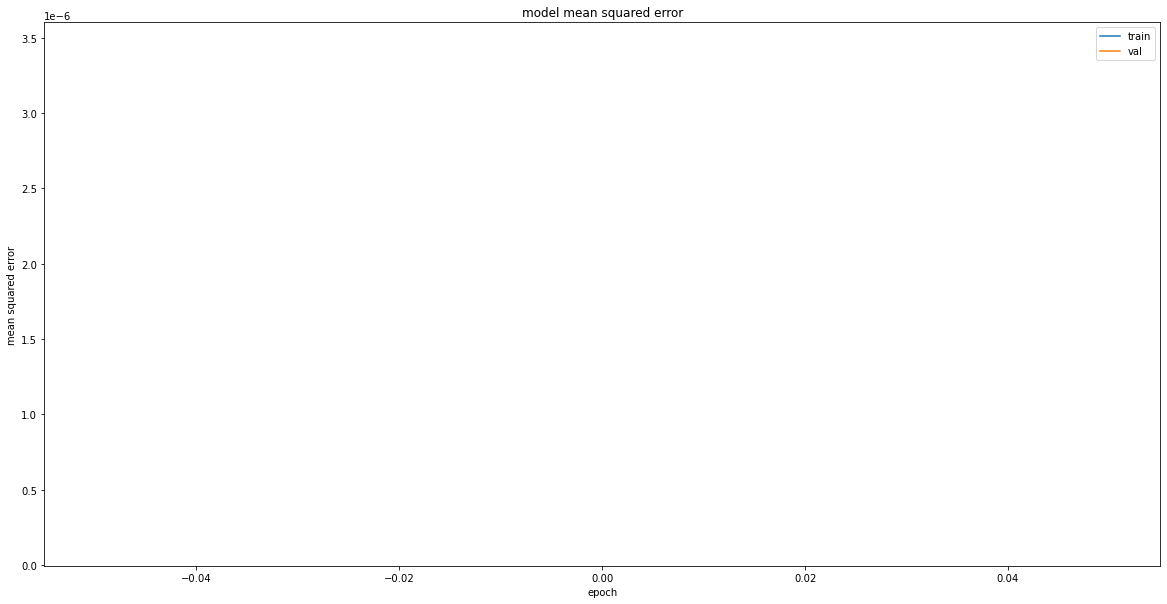

In [29]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

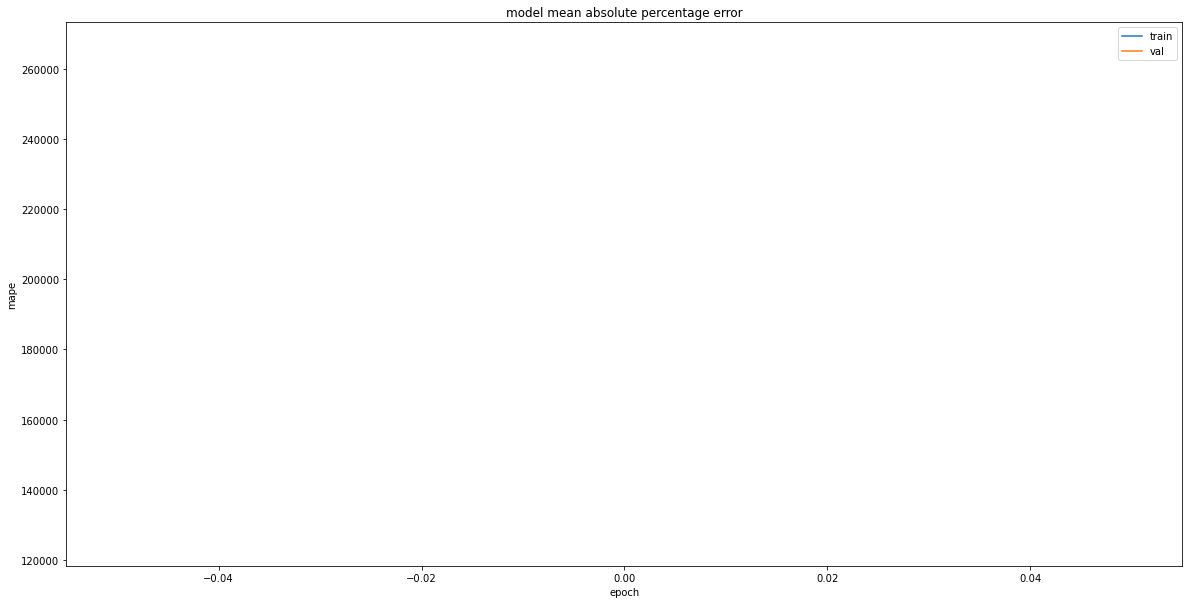

In [30]:
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mean absolute percentage error')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### insights
This model learns quite well 20 epochs in

## Evaluating model on new (unseen data)
should be the %age off of predicting the horizon price

In [31]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_dense_multivariate")
loss = model_6.evaluate(X_test, y_test)

  33/1080 [..............................] - ETA: 5s - loss: 3.6409e-04 - mse: 1.7261e-07 - mape: 43965.3555 - mae: 3.6409e-04

2022-02-08 15:08:34.931950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1080/1080 [==============================] - 4s 4ms/step - loss: 3.5718e-04 - mse: 1.6854e-07 - mape: 90416.2969 - mae: 3.5718e-04


In [32]:
# percentage
y_pred = model_6.predict(X_test)

2022-02-08 15:08:39.418253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [33]:
type(y_pred)

numpy.ndarray

In [34]:
y_pred

array([[-4.1301470e-04],
       [-4.3836876e-04],
       [-4.3762781e-04],
       ...,
       [-2.6716609e-04],
       [-3.5082374e-04],
       [-4.2691365e-05]], dtype=float32)

In [35]:
y_test = np.array(y_test)

In [36]:
type(y_test)

numpy.ndarray

In [37]:
y_test

array([ 5.7333345e-05,  5.2818090e-05, -5.3348940e-05, ...,
       -7.7742166e-05,  1.4537053e-04,  5.3484901e-04], dtype=float32)

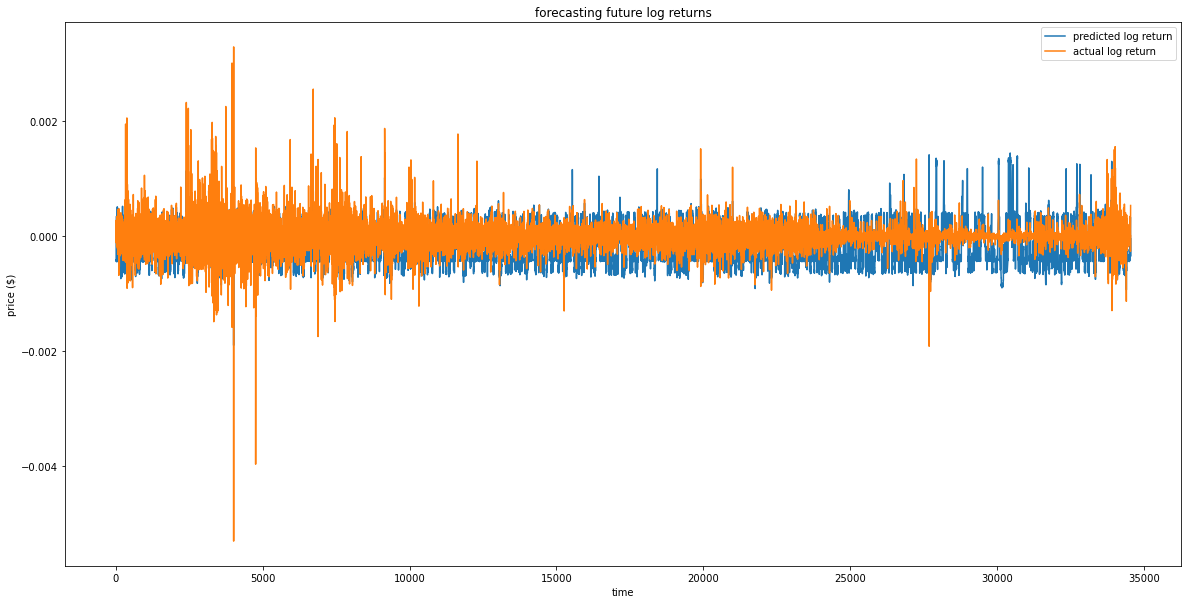

In [38]:
plt.plot(y_pred, label="predicted log return")
plt.plot(y_test, label="actual log return")
plt.title('forecasting future log returns')
plt.ylabel('price ($)')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.show()

In [39]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

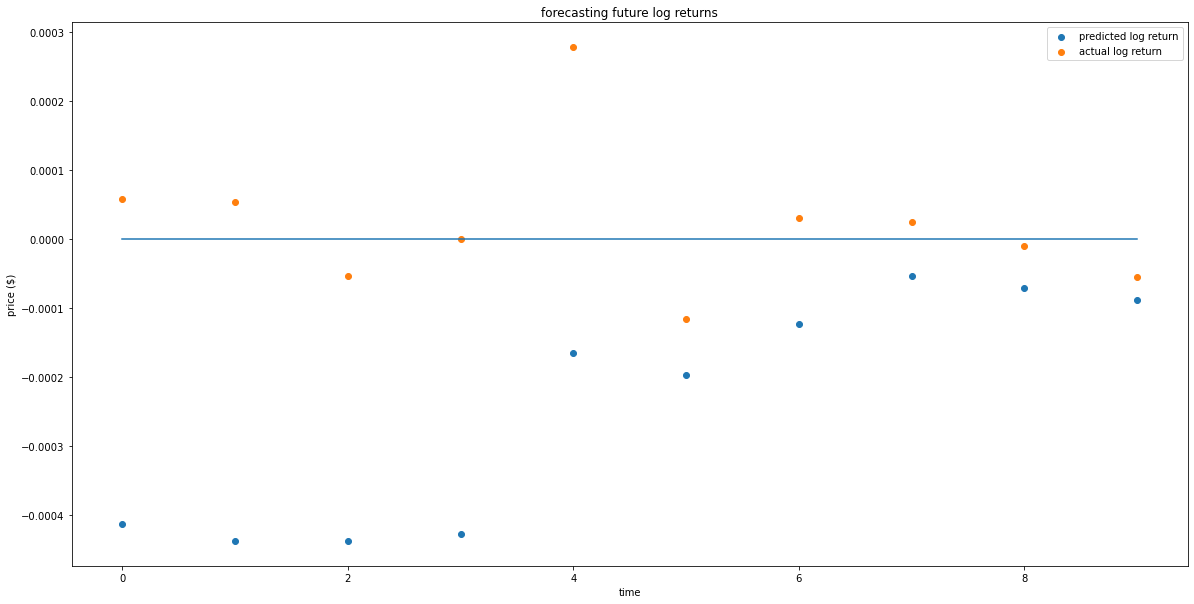

In [40]:
plt.scatter(x=np.arange(10), y=y_pred[:10], label="predicted log return",)
plt.scatter(x=np.arange(10), y=y_test[:10], label="actual log return")
plt.plot(np.zeros(10))
plt.title('forecasting future log returns')
plt.ylabel('price ($)')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.show()

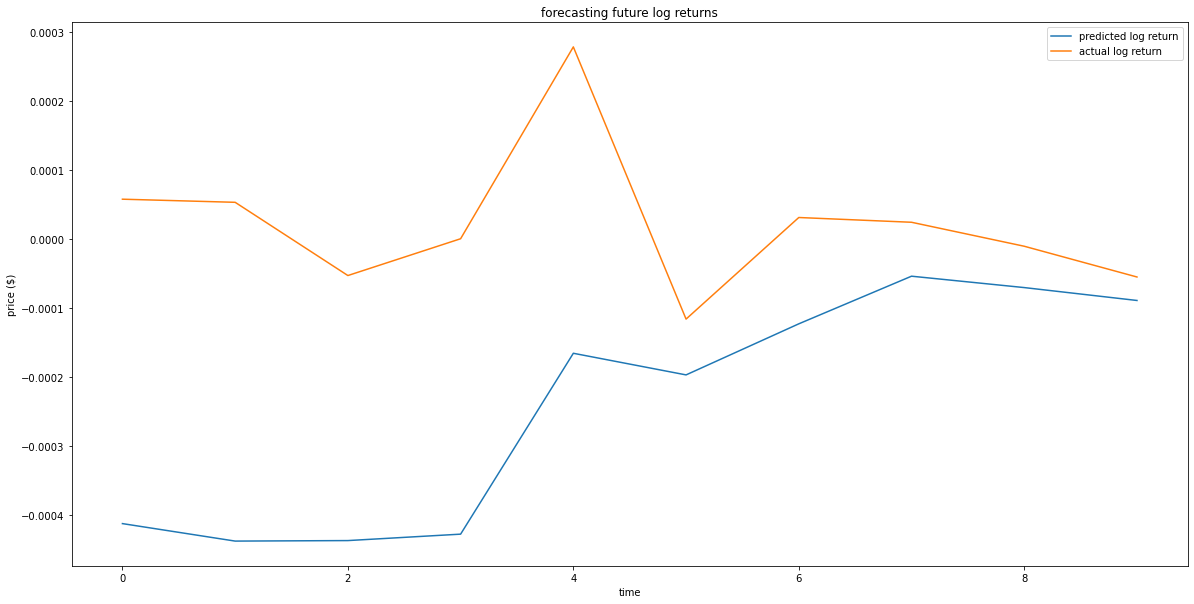

In [41]:
plt.plot(y_pred[:10], label="predicted log return",)
plt.plot(y_test[:10], label="actual log return")
plt.title('forecasting future log returns')
plt.ylabel('price ($)')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.show()

## Go from log returns back to price

initial price should be price at X_test.timestamp-1

In [42]:
p_0 = X_test

In [43]:
# 1 step back as p_initial
p_0_time = X_test.index[0] - pd.Timedelta(X_test.index[0].freq)

In [44]:
p_0_test = df.loc[p_0_time]['Close']

### The price should be initial_price * exp(log_ret.cumsum())

In [45]:
tot_return_pct = y_pred.cumsum()
tot_return_pct

array([-4.1301470e-04, -8.5138343e-04, -1.2890112e-03, ...,
       -6.5769935e+00, -6.5773444e+00, -6.5773873e+00], dtype=float32)

In [46]:
y_pred_prices = p_0_test*np.exp(y_pred.cumsum())

In [47]:
y_actual_prices = p_0_test*np.exp(y_test.cumsum())

In [48]:
len(y_pred_prices), len(y_actual_prices)

(34554, 34554)

In [49]:
y_pred_prices[:500]

array([37657.77 , 37641.266, 37624.797, 37608.688, 37602.44 , 37595.02 ,
       37590.383, 37588.34 , 37585.68 , 37582.316, 37579.586, 37576.758,
       37575.89 , 37580.977, 37592.125, 37605.117, 37618.215, 37630.562,
       37641.4  , 37644.652, 37642.76 , 37635.527, 37629.61 , 37619.465,
       37603.09 , 37586.84 , 37570.34 , 37553.766, 37536.996, 37520.773,
       37504.656, 37492.363, 37481.605, 37467.254, 37461.168, 37461.543,
       37475.473, 37486.3  , 37499.34 , 37511.77 , 37524.79 , 37538.867,
       37558.06 , 37563.098, 37571.984, 37580.35 , 37592.023, 37600.855,
       37607.453, 37616.39 , 37623.445, 37630.4  , 37636.754, 37642.72 ,
       37646.69 , 37651.543, 37662.883, 37672.098, 37686.008, 37695.17 ,
       37702.27 , 37701.62 , 37700.094, 37707.97 , 37712.414, 37719.824,
       37724.61 , 37739.17 , 37757.18 , 37772.1  , 37784.31 , 37801.68 ,
       37820.004, 37829.48 , 37834.367, 37841.88 , 37852.426, 37866.355,
       37873.742, 37888.62 , 37897.812, 37903.785, 

In [50]:
y_actual_prices

array([37675.49 , 37677.477, 37675.47 , ..., 41545.98 , 41552.016,
       41574.246], dtype=float32)

In [51]:
df['Close'][-10:]

2022-02-04 23:59:50    41559.41
2022-02-04 23:59:51    41559.41
2022-02-04 23:59:52    41560.00
2022-02-04 23:59:53    41560.00
2022-02-04 23:59:54    41556.62
2022-02-04 23:59:55    41545.77
2022-02-04 23:59:56    41549.21
2022-02-04 23:59:57    41545.98
2022-02-04 23:59:58    41552.02
2022-02-04 23:59:59    41574.25
Freq: S, Name: Close, dtype: float64

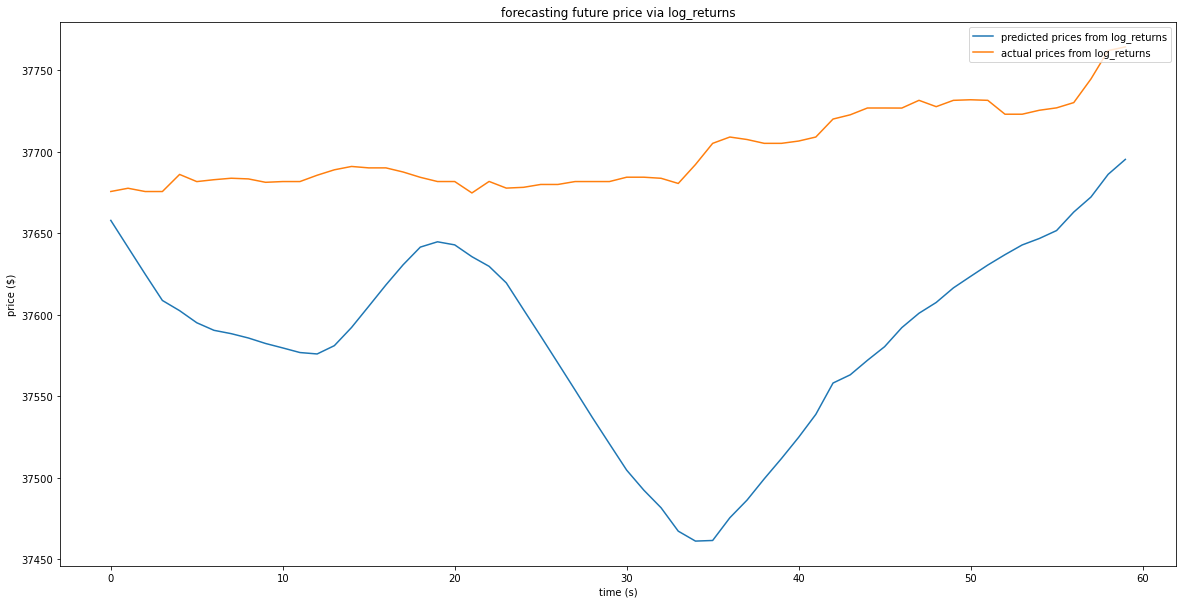

In [52]:
plt.plot(y_pred_prices[:60], label="predicted prices from log_returns")
plt.plot(y_actual_prices[:60], label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()

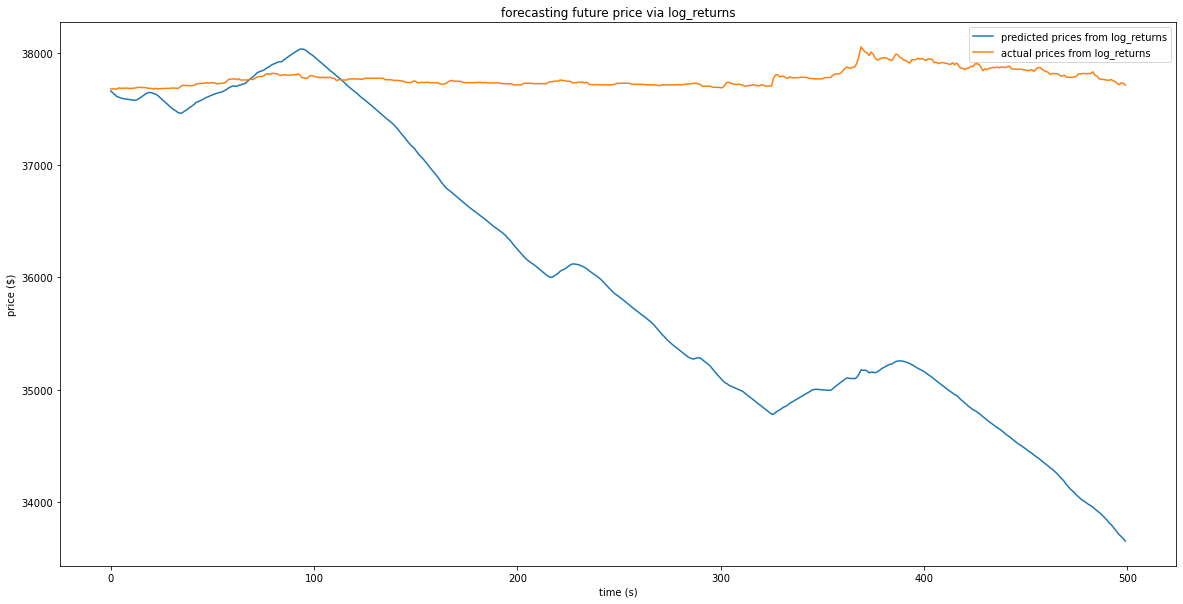

In [53]:
plt.plot(y_pred_prices[:500], label="predicted prices from log_returns")
plt.plot(y_actual_prices[:500], label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()

### Observation: is okay for the first bit of data beyond train/val set, approx 50seconds, afterwards it flies!

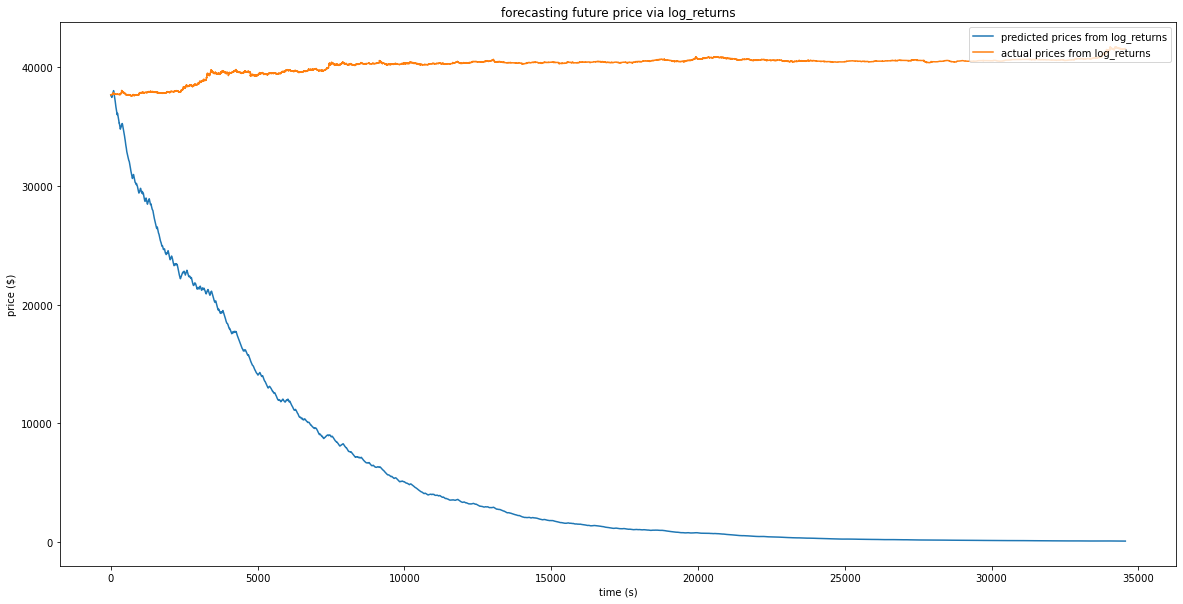

In [54]:
# for example, on the whole testing set
plt.plot(y_pred_prices, label="predicted prices from log_returns")
plt.plot(y_actual_prices, label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()